In [8]:
import numpy as np
import matplotlib.pyplot as plt
import torch, torchvision
from torchvision import transforms as T
import torch.nn as nn
import torch.nn.functional as nnF
import data_loader

In [9]:
#Import and initialize dataloaders
train_loader, val_loader, test_loader = data_loader.get_dataloader(path="~/Projects/COVID19-Transfer-Learning/COVID19-Transfer-Learning/Data/")

In [10]:
#Create model
class FeatureExtractorNetwork(nn.Module):
    def __init__(self, model):
        super(FeatureExtractorNetwork, self).__init__()
        
        #Feature extractor
        self.features = nn.Sequential(*list(model.children())[:-1])
        self.features.trainable = False
        layers = list(model.children())
        features = layers[-1].in_features
        self.flatten = nn.Flatten()
        
        #Fully connected layers
        self.fc1 = nn.Linear(features, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 1)
        
    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = nnF.relu(self.fc1(x))
        x = nnF.relu(self.fc2(x))
        x = nnF.sigmoid(self.fc3(x))
        return x

In [11]:
#Check that model runs on a random tensor
model = FeatureExtractorNetwork(torchvision.models.resnet18())
x=torch.randn(1,3,224,224)
x = model(x)
print(x)

tensor([[0.4787]], grad_fn=<SigmoidBackward0>)


In [12]:
#Initialize device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
#Define training function
def train(model,optimizer,train_dataloader,val_dataloader,criterion):
    #Set model to training mode
    model.train()
    
    #Initialize loss and accuracy
    train_loss = 0
    train_accuracy = 0
    
    for data in train_dataloader:
        #Get data and labels
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        #Zero the gradients
        optimizer.zero_grad()
        
        #Forward pass
        outputs = model(inputs).flatten()
        loss = criterion(outputs, labels.float())
        
        #Backward pass
        loss.backward()
        optimizer.step()
        
        #Calculate loss and accuracy
        train_loss += loss.item()
        train_accuracy += (outputs.round() == labels).sum().item()
    
    #Calculate average loss and accuracy
    train_loss /= len(train_dataloader)
    train_accuracy /= len(train_dataloader.dataset)
    
    #Initialize loss and accuracy
    val_loss = 0
    val_accuracy = 0
    
    for data in val_dataloader:
        #Get data and labels
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        #Forward pass
        outputs = model(inputs).flatten()
        loss = nnF.binary_cross_entropy(outputs, labels.float())
        
        #Calculate loss and accuracy
        val_loss += loss.item()
        val_accuracy += (outputs.round() == labels).sum().item()
    
    #Calculate average loss and accuracy
    val_loss /= len(val_dataloader)
    val_accuracy /= len(val_dataloader.dataset)
    
    return train_loss, train_accuracy, val_loss, val_accuracy

#### From Scratch

In [17]:
resnet50 = torchvision.models.resnet50()
model = FeatureExtractorNetwork(resnet50).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
criterion = nn.BCELoss()

loss_train_list=[]
acc_train_list=[]
loss_val_list = []
acc_val_list = []

best_val = 0
best_model = None

for epoch in range(0, 100):
    #-------- perform training --------------------------------
    loss_train, acc_train, loss_val, acc_val = train(model,optimizer,train_loader,val_loader,criterion)
    loss_train_list.append(loss_train)
    acc_train_list.append(acc_train)
    loss_val_list.append(loss_val)
    acc_val_list.append(acc_val)
    
    if acc_val > best_val:
        best_val = acc_val
        best_model = model.state_dict()
        

    print('epoch', epoch, 'training loss:', loss_train, 'acc:', acc_train, 'val acc:', acc_val)

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacity of 79.20 GiB of which 1.31 MiB is free. Process 29349 has 3.97 GiB memory in use. Process 195910 has 938.00 MiB memory in use. Process 294368 has 3.82 GiB memory in use. Process 299660 has 2.84 GiB memory in use. Process 648822 has 1.55 GiB memory in use. Process 650818 has 2.84 GiB memory in use. Process 840057 has 59.88 GiB memory in use. Including non-PyTorch memory, this process has 3.34 GiB memory in use. Of the allocated memory 1.68 GiB is allocated by PyTorch, and 56.42 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

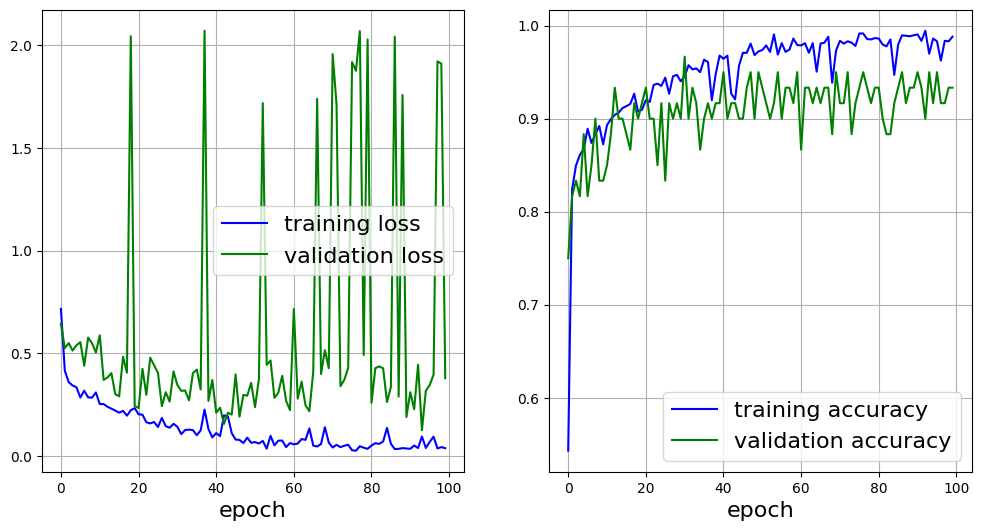

In [ ]:
#Plot the loss and accuracy results
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].plot(np.arange(0,len(loss_train_list)), loss_train_list, '-b', label='training loss')
ax[0].plot(np.arange(0,len(loss_val_list)), loss_val_list, '-g', label='validation loss')
ax[0].set_xlabel('epoch',fontsize=16)
ax[0].legend(fontsize=16)
ax[0].grid(True)
ax[1].plot(np.arange(0,len(acc_train_list)), acc_train_list, '-b', label='training accuracy')
ax[1].plot(np.arange(0,len(acc_val_list)), acc_val_list, '-g', label='validation accuracy')
ax[1].set_xlabel('epoch',fontsize=16)
ax[1].legend(fontsize=16)
ax[1].grid(True)

In [ ]:
model.load_state_dict(best_model)
test_accuracy = 0

for data in test_loader:
    #Get data and labels
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    
    #Forward pass
    outputs = model(inputs).flatten()
    loss = nnF.binary_cross_entropy(outputs, labels.float())
    
    #Calculate accuracy
    test_accuracy += (outputs.round() == labels).sum().item()
    
#Calculate average loss and accuracy
test_accuracy /= len(test_loader.dataset)
print(test_accuracy)

0.92


#### Pretrained Model

In [ ]:
pre_trained_resnet50 = torchvision.models.resnet50(weights='IMAGENET1K_V2')
for param in pre_trained_resnet50.parameters():
    param.requires_grad = False
pre_trained_model = FeatureExtractorNetwork(pre_trained_resnet50).to(device)

optimizer = torch.optim.Adam(pre_trained_model.parameters(), lr=0.001, weight_decay=0.0001)
criterion = nn.BCELoss()

loss_train_list=[]
acc_train_list=[]
loss_val_list = []
acc_val_list = []

best_val = 0
best_model = None

for epoch in range(0, 100):
    #-------- perform training --------------------------------
    loss_train, acc_train, loss_val, acc_val = train(pre_trained_model,optimizer,train_loader,val_loader,criterion)
    loss_train_list.append(loss_train)
    acc_train_list.append(acc_train)
    loss_val_list.append(loss_val)
    acc_val_list.append(acc_val)
    
    if acc_val > best_val:
        best_val = acc_val
        best_model = pre_trained_model.state_dict()
        

    print('epoch', epoch, 'training loss:', loss_train, 'acc:', acc_train, 'val acc:', acc_val)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /fs/johnston/home/cole/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100.0%


epoch 0 training loss: 0.38499077479355037 acc: 0.824431256181998 val acc: 0.8333333333333334
epoch 1 training loss: 0.1985697787895333 acc: 0.9218595450049456 val acc: 0.8833333333333333
epoch 2 training loss: 0.1697084629558958 acc: 0.933728981206726 val acc: 0.8666666666666667
epoch 3 training loss: 0.11465871657128446 acc: 0.9574678536102869 val acc: 0.8166666666666667
epoch 4 training loss: 0.16470417979871854 acc: 0.9357072205736894 val acc: 0.8833333333333333
epoch 5 training loss: 0.07467514682502951 acc: 0.9713155291790306 val acc: 0.8666666666666667
epoch 6 training loss: 0.08112352582247695 acc: 0.9658753709198813 val acc: 0.8666666666666667
epoch 7 training loss: 0.044811048632254824 acc: 0.9851632047477745 val acc: 0.8333333333333334
epoch 8 training loss: 0.0559148293978069 acc: 0.9777448071216617 val acc: 0.8666666666666667
epoch 9 training loss: 0.04338080238676412 acc: 0.9861523244312562 val acc: 0.9166666666666666
epoch 10 training loss: 0.05997428783120995 acc: 0.976

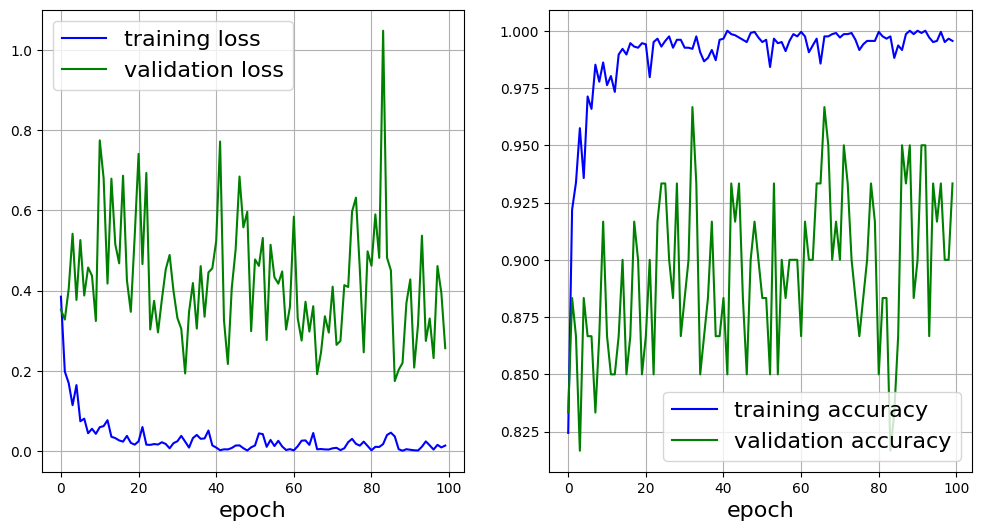

In [ ]:
#Plot the loss and accuracy results
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].plot(np.arange(0,len(loss_train_list)), loss_train_list, '-b', label='training loss')
ax[0].plot(np.arange(0,len(loss_val_list)), loss_val_list, '-g', label='validation loss')
ax[0].set_xlabel('epoch',fontsize=16)
ax[0].legend(fontsize=16)
ax[0].grid(True)
ax[1].plot(np.arange(0,len(acc_train_list)), acc_train_list, '-b', label='training accuracy')
ax[1].plot(np.arange(0,len(acc_val_list)), acc_val_list, '-g', label='validation accuracy')
ax[1].set_xlabel('epoch',fontsize=16)
ax[1].legend(fontsize=16)
ax[1].grid(True)

In [ ]:
pre_trained_model.load_state_dict(best_model)
test_accuracy = 0

for data in test_loader:
    #Get data and labels
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    
    #Forward pass
    outputs = pre_trained_model(inputs).flatten()
    loss = nnF.binary_cross_entropy(outputs, labels.float())
    
    #Calculate accuracy
    test_accuracy += (outputs.round() == labels).sum().item()
    
#Calculate average loss and accuracy
test_accuracy /= len(test_loader.dataset)
print(test_accuracy)

0.9375


### CAM Analysis

#### GradCAM

In [7]:
from pytorch_grad_cam import GradCAM

scratch_cam = GradCAM(model=model, target_layer=model.layer4[-1], use_cuda=True)

NameError: name 'model' is not defined